# Libraries

In [2]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

# Data loading and exploration

In [55]:
IMG_SHAPE  = 299
batch_size = 32
random_seed = 9

In [56]:
fpath = './Dataset_RemovedBG'
categories = os.listdir(fpath)
categories.pop(1)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['totally_green', 'yellow_with_brown_spots', 'yellow_with_green_tips'] 

No. of categories =  3


In [57]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  288 
No. of labels loaded =  288
<class 'list'> <class 'list'>


In [58]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (288, 299, 299, 3) 
Labels shape =  (288,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


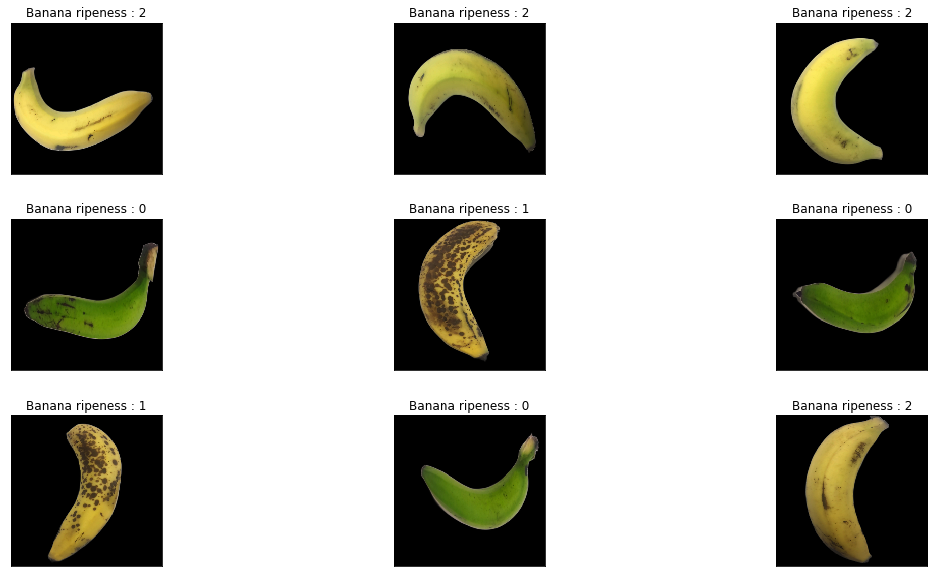

In [59]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Banana ripeness : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [60]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

In [61]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (288, 299, 299, 3) 
Labels shape after shuffling =  (288,)


In [62]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (288, 299, 299, 3)


In [63]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (172, 299, 299, 3)
y_train shape =  (172,)

x_test shape =  (58, 299, 299, 3)
y_test shape =  (58,)

x_val shape =  (58, 299, 299, 3)
y_val shape =  (58,)


In [64]:
##One-hot-encode
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

# Define CNN model

In [65]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

In [66]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_2
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_4
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_5
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111
batch_normalization_112
activation_106
activation_108
activation

In [67]:
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

# Train model

In [68]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [69]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

__________________________________________________________________________________________________
activation_106 (Activation)     (None, 35, 35, 64)   0           batch_normalization_106[0][0]    
__________________________________________________________________________________________________
activation_108 (Activation)     (None, 35, 35, 64)   0           batch_normalization_108[0][0]    
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 35, 35, 96)   0           batch_normalization_111[0][0]    
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 35, 35, 64)   0           batch_normalization_112[0][0]    
__________________________________________________________________________________________________
mixed1 (Concatenate)            (None, 35, 35, 288)  0           activation_106[0][0]             
          

In [70]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [71]:
x_train.shape,y_train.shape

((172, 299, 299, 3), (172, 3))

In [72]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-basedTL_InceptionV3log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
5/5 [==============================] - 10s 2s/step - loss: 3.5147 - acc: 0.5125 - val_acc: 1.0000 - val_loss: 0.0183
Epoch 2/50
5/5 [==============================] - 9s 2s/step - loss: 0.8176 - acc: 0.8643 - val_acc: 1.0000 - val_loss: 0.0017
Epoch 3/50
5/5 [==============================] - 8s 2s/step - loss: 0.5653 - acc: 0.9071 - val_acc: 0.9688 - val_loss: 0.0726
Epoch 4/50
5/5 [==============================] - 8s 2s/step - loss: 0.3050 - acc: 0.9500 - val_acc: 1.0000 - val_loss: 4.3854e-04
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 0.1894 - acc: 0.9643 - val_acc: 1.0000 - val_loss: 4.1029e-04
Epoch 6/50
5/5 [==============================] - 7s 1s/step - loss: 0.1227 - acc: 0.9714 - val_acc: 1.0000 - val_loss: 0.0173
Epoch 7/50
5/5 [==============================] - 9s 2s/step - loss: 0.1782 - acc: 0.9375 - val_acc: 1.0000 - val_loss: 3.5053e-04
Epoch 8/50
5/5 [==============================] - 9s 2s/step - loss: 0.1185 - acc: 0.9714 - val_ac

In [73]:
model_json = model.to_json()
with open("CNN-based TL model/InceptionV3_Banana_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("CNN-based TL model/InceptionV3_Banana_Classifier.h5")
print("Saved model to disk")
model.save_weights("CNN-based TL model/InceptionV3_Banana.h5")

Saved model to disk


# Evaluation model

In [74]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

2/2 [==============================] - 1s 724ms/step - loss: 0.4208 - acc: 0.9655
test_loss: 42.08
test_accuracy: 96.55


In [75]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 96.55
F1 score: 96.59
Precision: 96.96
Recall: 96.55


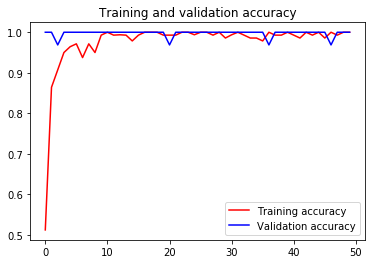

In [76]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show()